In [1]:
 #librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit

from os import listdir
from os.path import isfile, join
import os

import warnings

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
###########################################
#                                         #
#    CHANGE ONLY THIS CELL IN THE CODE    #
#                                         #
###########################################

data_dir="drive/MyDrive/Lab HPGE/Data"        
source="/Cs137"                               
detector="/NaI"                                
threshold_caen="14500"                         


gain_preampl="100" #useful only for germanium detector           

In [4]:
threshold="/THR_"+threshold_caen
gain="__GAIN_"+gain_preampl


if detector[1:]=="Ge":
    path_to_directory=data_dir+detector+source+threshold+gain   # do not change this. Change the part above
elif detector[1:]=="NaI":
    path_to_directory=data_dir+detector+source+threshold        # do not change this. Change the part above

In [5]:
warnings.filterwarnings("ignore")

sample_space=10e-9 #10 ns
samples_per_event=8192 

time_axis=np.linspace(sample_space,samples_per_event*sample_space,samples_per_event)  # from 10 ns to 8192*10 ns 
samples_axis=np.linspace(1,8192,8192) # from 1 to 8192



    #             _________________
    #            /|               |\
    #           / |               | \
    # ---------/---------------------\-------------------
    #_________/   |               |   \______________
    #         |   |    plateau    |   |
    #         |   |               |   |
    # small   |   |___            |   |_     small points
    # points  | graph |           |graph|       dx
    #  sx     |   sx  |           | dx  |
    #
    #


saturation_point=16383 #limit points saturation
threshold_value=50

def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

def gaussianh(x, N, mu,sigma,h):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)+h

In [6]:
try:
    files_name_xml = ["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name)) and file_name[-3:]=="xml"]
    print("Xml:   ", files_name_xml)
    sat_file_name=[file_name[:-4]+"_sat.txt" for file_name in files_name_xml]
    unsat_file_name=[file_name[:-4]+"_unsat.txt" for file_name in files_name_xml]
    print("Sat:   ", sat_file_name)
    print("Unsat: ", unsat_file_name)
except:
    print("Folder not found!. Check if the values two cells above are correct.")

Xml:    ['/NaI_Cs137_1100V_14500_1.xml', '/NaI_Cs137_1100V_14500_2.xml', '/NaI_Cs137_1100V_14500_3.xml']
Sat:    ['/NaI_Cs137_1100V_14500_1_sat.txt', '/NaI_Cs137_1100V_14500_2_sat.txt', '/NaI_Cs137_1100V_14500_3_sat.txt']
Unsat:  ['/NaI_Cs137_1100V_14500_1_unsat.txt', '/NaI_Cs137_1100V_14500_2_unsat.txt', '/NaI_Cs137_1100V_14500_3_unsat.txt']


In [7]:
files_in_directory=["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name))]

files_names=zip(files_name_xml,sat_file_name,unsat_file_name)
#output of the code below: a txt file for each xml file that contains all the events of that run 

###############################################
#                                             #
#               GERMANIUM                     #
#                                             #
###############################################



if detector[1:]=="Ge":
    for xml_name,sat_name,unsat_name in files_names:
        if sat_name in files_in_directory and unsat_name in files_in_directory:
            print("\n##################################################################################\n")
            print("Files: ",sat_name," and ",unsat_name , " already present in: ",path_to_directory)
            print("\n")
        else:
            print("\n##################################################################################\n")
            print("Start working on: ",xml_name)

            list_event=[]
            maxima_peaks=[]
            cupola=[]
            index_saturated=[]

            non_sat_values_integrals=[]
            sat_values_integrals=[]
            index_problematic=[]

            path_to_file=path_to_directory+xml_name
            tree = ET.parse(path_to_file) 
            root=tree.getroot()
            
            for event in root.findall("event"):  #this finds all the event in the file
                string_event=event.find("trace").text  #this takes all the samples for each event
                int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
                list_event.append(int_event)
            
            list_event_array=np.array(list_event)

            print("Parsing of  ",xml_name, " completed!")
            print("Start working on saturation problem.")
            

            maxima_peaks=np.zeros(len(list_event_array))
            list_event_array.max(axis=1,out=maxima_peaks)
            index_saturated=[i for i in range(len(maxima_peaks)) if(maxima_peaks[i]==saturation_point)]

            for index_event in index_saturated:
                sx=[]
                dx=[]
                graph_sx=[]
                graph_dx=[]
                small_points_dx=[]
                small_points_sx=[]
                plateau_points=[]



                event=list_event_array[index_event] #select the event

                #dividing the event in 5 parts on the x-axis...
                plateau_points=[i for i in range(len(event)) if(event[i]==saturation_point)]

                small_points_sx=[i for i in range(len(event)) if(event[i]<threshold_value and i<plateau_points[0])]
                sx=[i for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
                dx=[i for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
                small_points_dx=[i for i in range(len(event)) if(event[i]<threshold_value and i>plateau_points[0])]
                
                # ... and in 2 in the y axis
                graph_sx=[event[i] for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
                graph_dx=[event[i] for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]

                #filling the right arrays
                x_graph=np.zeros(len(sx)+len(dx))
                np.concatenate((sx,dx),out=x_graph)
                graph=np.zeros(len(graph_sx)+len(graph_dx))
                np.concatenate((graph_sx,graph_dx),out=graph)
                graph_small_points_sx =event[small_points_sx]
                graph_small_points_dx = event[small_points_dx]

                #fit
                try:
                    init_vals = [saturation_point,plateau_points[int(len(plateau_points)/2)] ,len(plateau_points)]  # for [N,mu, wid]
                    best_vals, covar = curve_fit(gaussian, x_graph, graph,p0=init_vals)
                    
                    gaussian_event=gaussian(samples_axis,*best_vals)
                    cupola.append(np.concatenate((graph_small_points_sx,graph_sx,gaussian_event[plateau_points],graph_dx,graph_small_points_dx)))
                except:
                    index_problematic.append(index_event)

            tot_events=len(list_event_array)
            non_saturated_events = np.delete(list_event_array,index_saturated,axis=0)

            non_sat_values_integrals=[integrate.trapz(event,time_axis) for event in non_saturated_events] #evaluating the spectrum
            sat_values_integrals=[integrate.trapz(event,time_axis) for event in cupola]

            print("Integrals calculation of saturated and unsaturated events of: ",xml_name, " completed!")
            
            tot_sat_events=len(sat_values_integrals)
            tot_unsat_events=len(non_sat_values_integrals)
            tot_lost_events=len(index_problematic)
            

            print("\n##################################################################\n")
            print("Stats on this run: \n\t 1) Total events: \t{:d} \n\t 2) Sat. Events: \t{:d} ({:f}) % \n\t 2) UnSat. Events: \t{:d} ({:f}) % \n\t 2) Lost Events: \t{:d} ({:f}) %".format(tot_events,tot_sat_events,float(tot_sat_events)*100/tot_events,tot_unsat_events,float(tot_unsat_events)*100/tot_events,tot_lost_events,float(tot_lost_events)*100/tot_events))
            print("\n##################################################################\n")



            np.savetxt(path_to_directory+sat_name,sat_values_integrals)
            print("File: ",sat_name, "saved in the folder: ",path_to_directory)
            np.savetxt(path_to_directory+unsat_name,non_sat_values_integrals)
            print("File: ",unsat_name, "saved in the folder: ",path_to_directory)

            print("\n")

    print("\n##################################################################################\n")
###############################################
#                                             #
#                  NAI                        #
#                                             #
###############################################

elif detector[1:]=="NaI":
    for xml_name,sat_name,unsat_name in files_names:
            print("\n##################################################################################\n")
            print("Start working on: ",xml_name)

            path_to_file=path_to_directory+xml_name
            tree = ET.parse(path_to_file) 
            root=tree.getroot()
            
            list_event=[]
            index_saturated=[]
            minima_peaks=[]
            
            index_problematic=[]

            sat_events=[]
            non_sat_values_integrals=[]
            sat_values_integrals=[]         

            for event in root.findall("event"):  #this finds all the event in the file
                string_event=event.find("trace").text  #this takes all the samples for each event
                int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
                list_event.append(int_event)
            
            print("Parsing of  ",xml_name, " completed!")
            print("Start working on saturation problem.")
            
            list_event_array=np.array(list_event)
            minima_peaks=np.zeros(len(list_event_array))
            list_event_array.min(axis=1,out=minima_peaks)
            index_saturated=[i for i in range(len(minima_peaks)) if(minima_peaks[i]==0)]

            #baseline=list_event_array[:][-1000:]
            baseline=list_event[0][7700]

            background_value_NaI=baseline
            

            list_event_array=list_event_array-background_value_NaI     
            list_event_array=(-1)*list_event_array

            tot_events=len
            
            for index_event in index_saturated:
                try:
                    sat_events.append(list_event_array[index_event])
                except:
                    index_problematic.append(index_event)
            
            #non_saturated_events = np.delete(list_event_array,index_saturated,axis=0)
   
    print("\n##################################################################################\n")            
else:
    print("Detector not available!")


##################################################################################

Start working on:  /NaI_Cs137_1100V_14500_1.xml
Parsing of   /NaI_Cs137_1100V_14500_1.xml  completed!
Start working on saturation problem.

##################################################################################

Start working on:  /NaI_Cs137_1100V_14500_2.xml
Parsing of   /NaI_Cs137_1100V_14500_2.xml  completed!
Start working on saturation problem.

##################################################################################

Start working on:  /NaI_Cs137_1100V_14500_3.xml
Parsing of   /NaI_Cs137_1100V_14500_3.xml  completed!
Start working on saturation problem.

##################################################################################



In [8]:
def exp(x,a,h):
    a*np.exp(x)+h

(1600.0, 2000.0)

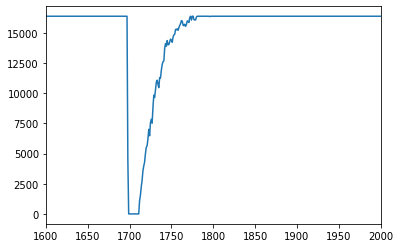

In [15]:
numb_event=index_saturated[402]

plt.plot(samples_axis,list_event[numb_event])
plt.xlim(1600,2000)

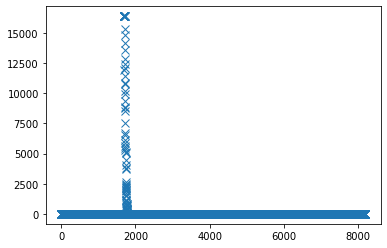

In [16]:
plt.plot(samples_axis,list_event_array[numb_event],ls="",marker="x",markersize=8)
#plt.xlim(0,200)
#plt.ylim(-100,100)

In [13]:
list_event[numb_event][7700]

16383